In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src.datasets import camvid
from src import evaluate
from src import plot
from src import predict
from src import predict_video
from src.tiramisu import aleatoric_tiramisu
from src.tiramisu import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# the location to save coarse training weights to
pretrain_weights = 'models/Tiramisu103-CamVid11-fine.h5'
# the location to save fine training weights to
weights_file = 'models/Tiramisu103-CamVid11-Aleatoric.h5'

In [3]:
# the size to crop images to for fine tune training
crop_size = (352, 480)
# the size of batches to use for training
batch_size = 1

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.CamVid.load_mapping(),
    target_size=(360, 480),
    crop_size=crop_size,
    batch_size=batch_size,
    horizontal_flip=True,
    ignored_labels=['Void'],
    y_repeats=1,
)
generators = camvid11.generators()

Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


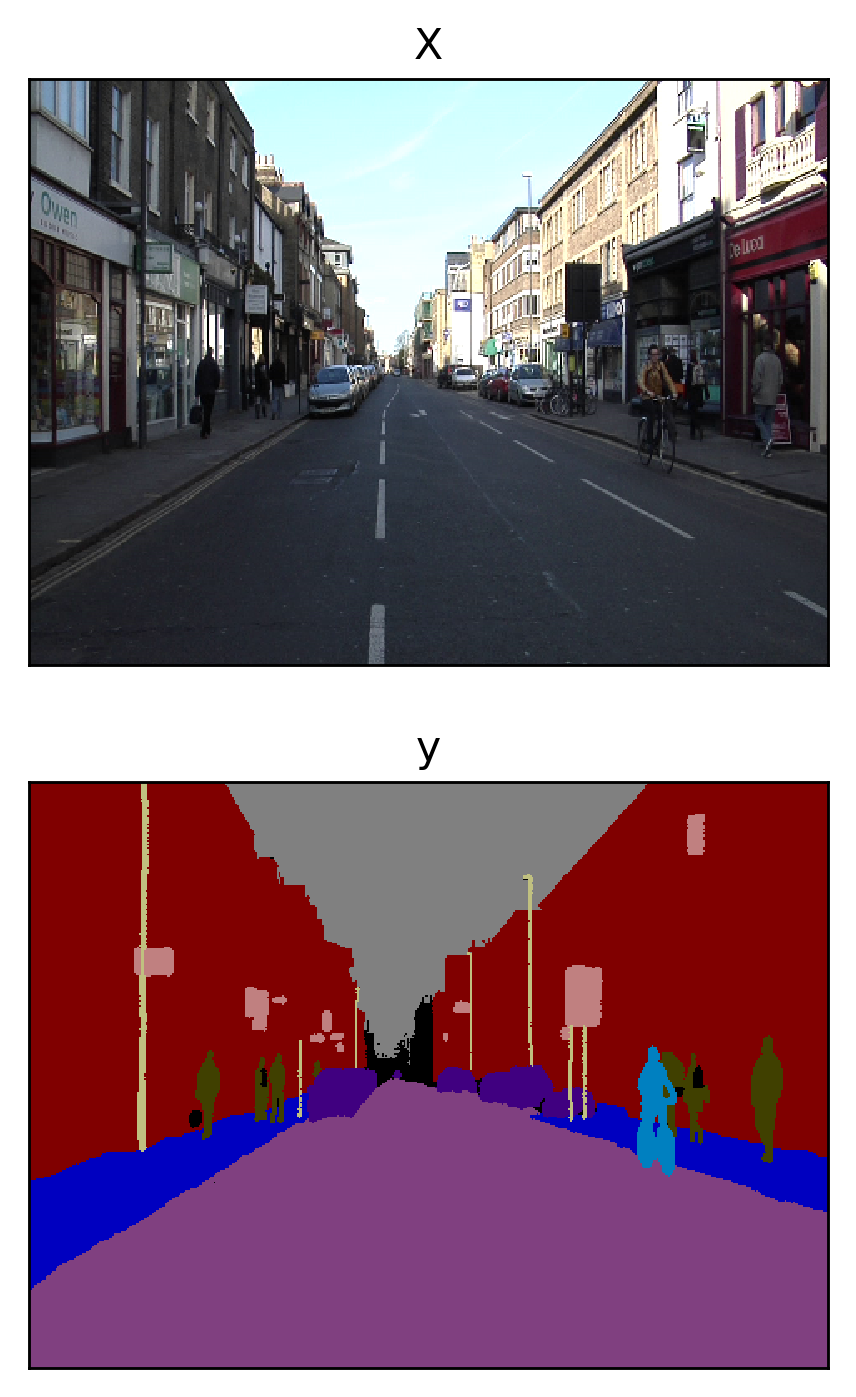

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y[0])
# plot the images
_ = plot.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = aleatoric_tiramisu.aleatoric_tiramisu((*crop_size, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-4,
    weights_file=pretrain_weights,
)
model.summary()

/users/PMIU0138/miu0212/neural-semantic-segmentation/src/tiramisu/aleatoric_tiramisu.py:87: UserWarning: Output "sigma" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "sigma" during training.
  metrics={'softmax': [build_categorical_accuracy(weights=class_weights)]},


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [7]:
callbacks = [
    EarlyStopping(monitor='val_aleatoric_loss', patience=10),
    ModelCheckpoint(weights_file,
        monitor='val_aleatoric_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    ),
    PlotMetrics(),
]

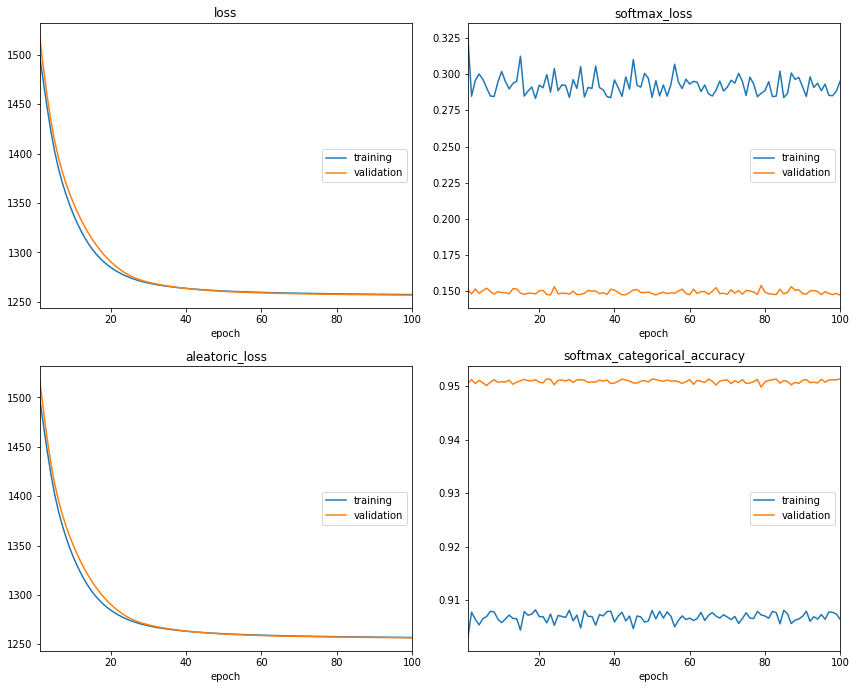

In [8]:
# fit the model with the data.
history = model.fit_generator(generators['train'],
    epochs=100,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=1,
)

In [9]:
history_to_results(history)

train          val
aleatoric_loss                1256.888468  1256.487953
loss                          1257.404369  1256.856857
softmax_categorical_accuracy     0.906447     0.951413
softmax_loss                     0.295244     0.147352

## Test Metrics

In [10]:
model.load_weights(weights_file)

In [11]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(weights_file + '.csv')
metrics

100%|██████████| 233/233 [01:49<00:00,  2.13step/s]


Value
Accuracy                 0.908092
Mean Per Class Accuracy  0.716523
Mean I/U                 0.585788
Bicyclist                0.348390
Building                 0.775576
Car                      0.689861
Column_Pole              0.312898
Fence                    0.261254
Pedestrian               0.429901
Road                     0.918804
Sidewalk                 0.802591
SignSymbol               0.253895
Sky                      0.918060
VegetationMisc           0.732444

In [12]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.908092 |
| Mean Per Class Accuracy | 0.716523 |
| Mean I/U                | 0.585788 |
| Bicyclist               | 0.34839  |
| Building                | 0.775576 |
| Car                     | 0.689861 |
| Column_Pole             | 0.312898 |
| Fence                   | 0.261254 |
| Pedestrian              | 0.429901 |
| Road                    | 0.918804 |
| Sidewalk                | 0.802591 |
| SignSymbol              | 0.253895 |
| Sky                     | 0.91806  |
| VegetationMisc          | 0.732444 |


## Qualitative Results

### Train

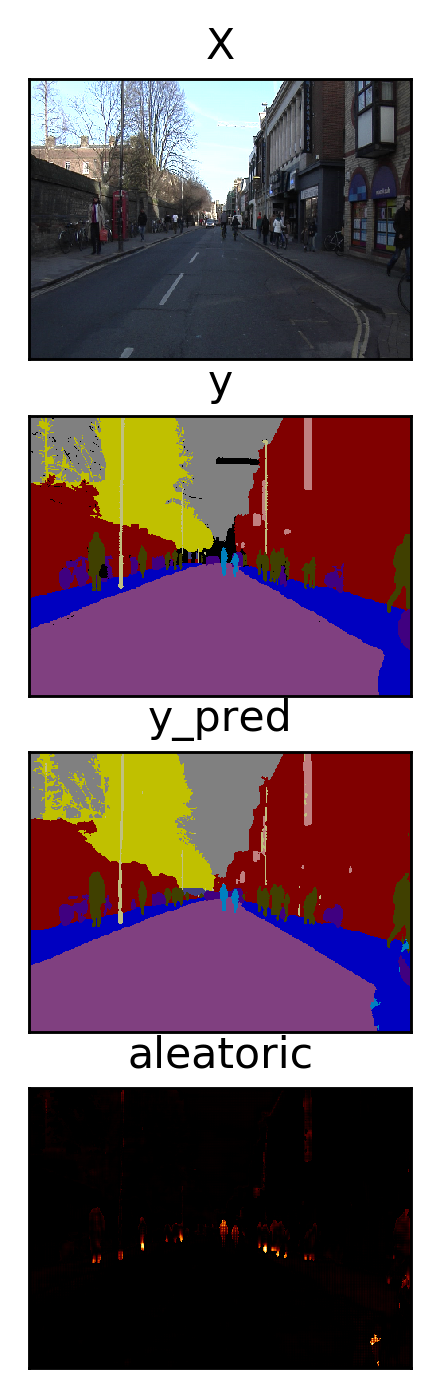

In [13]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

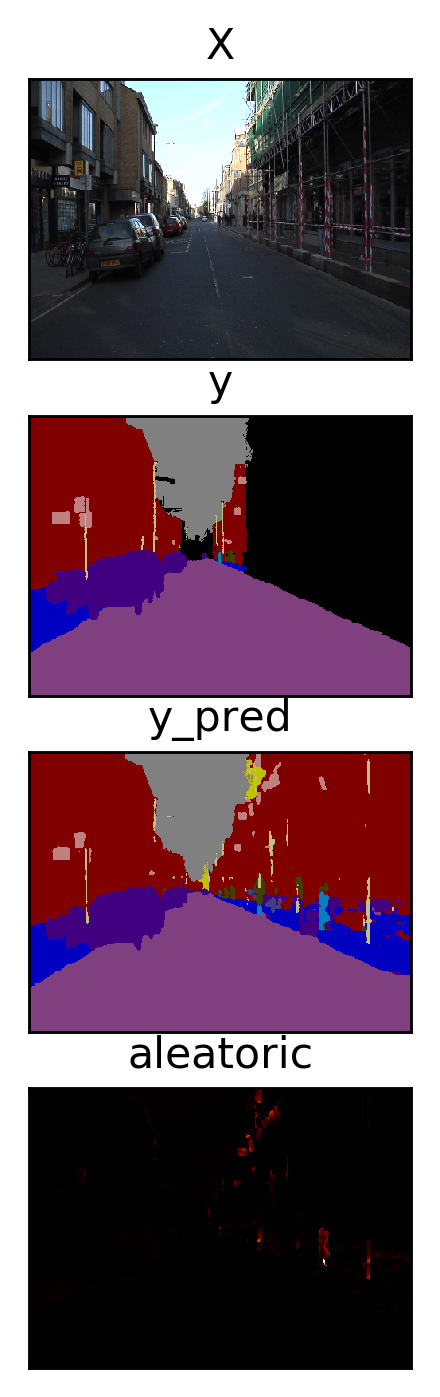

In [14]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

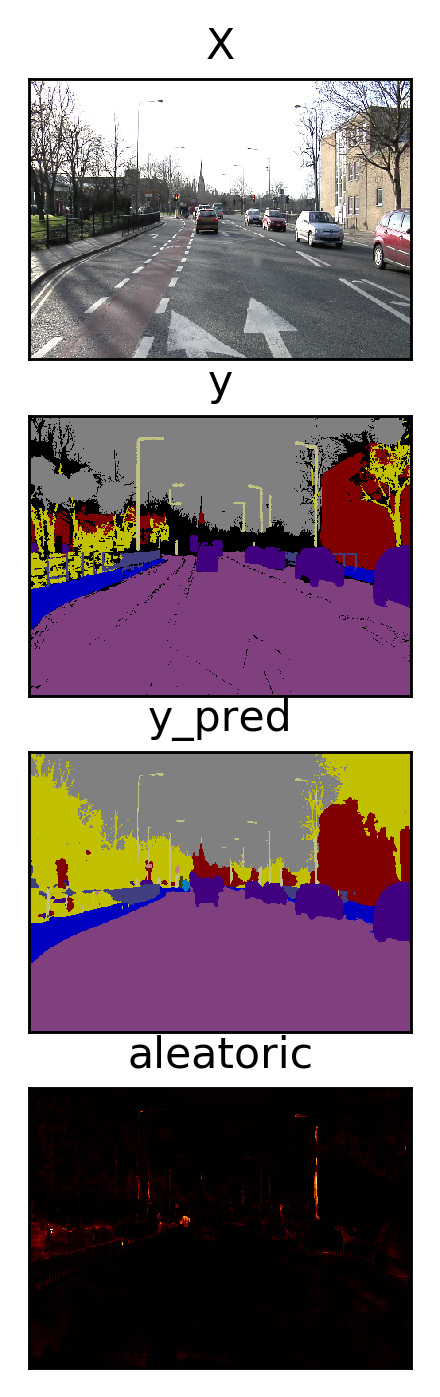

In [15]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

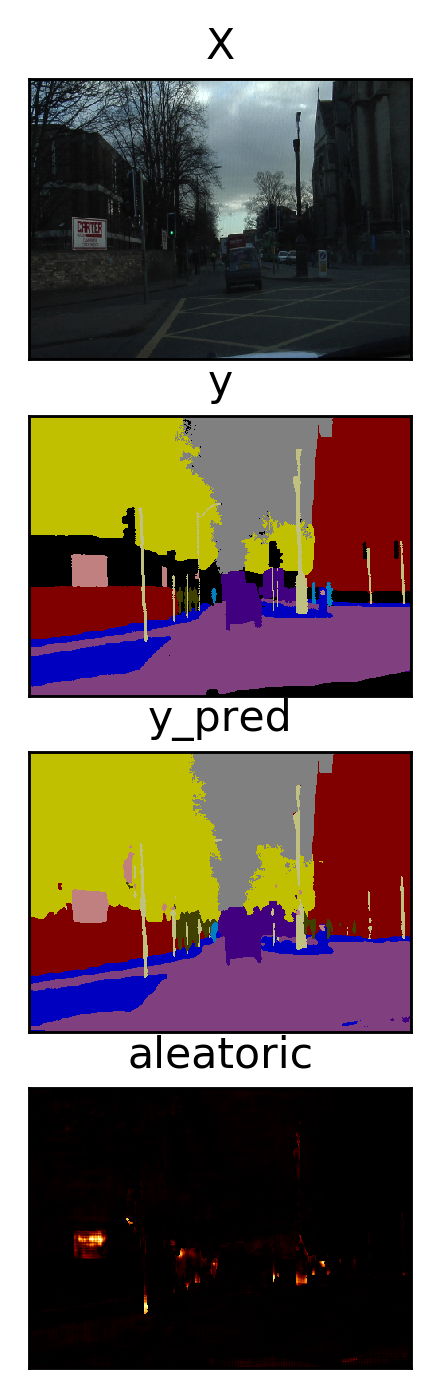

In [16]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

### Validation

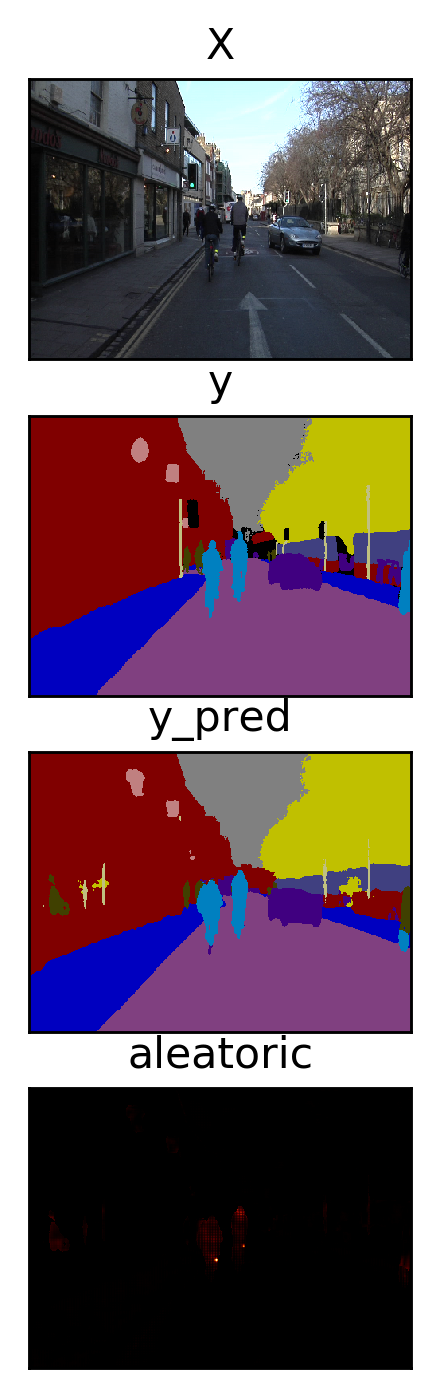

In [17]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

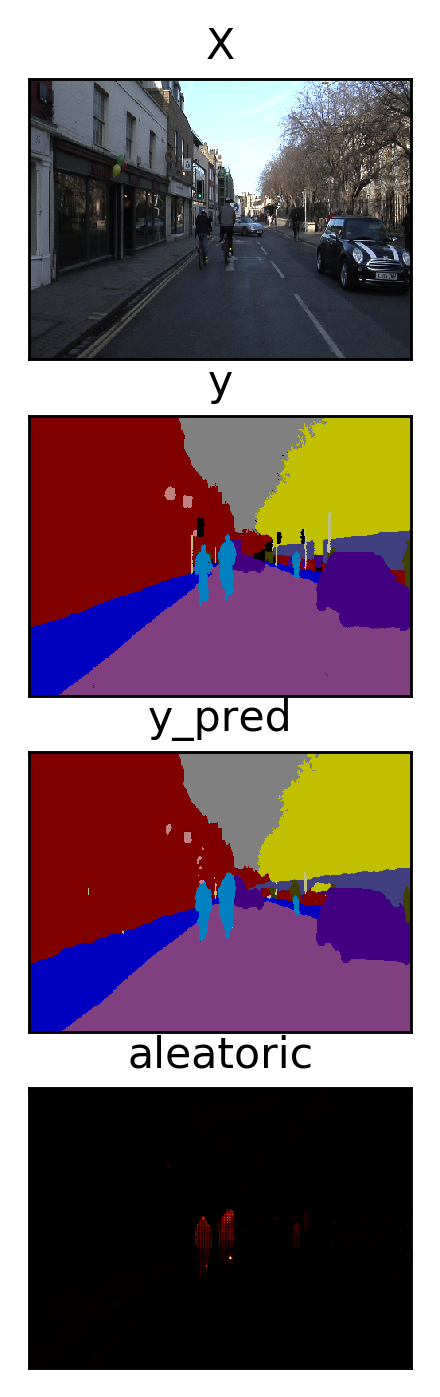

In [18]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

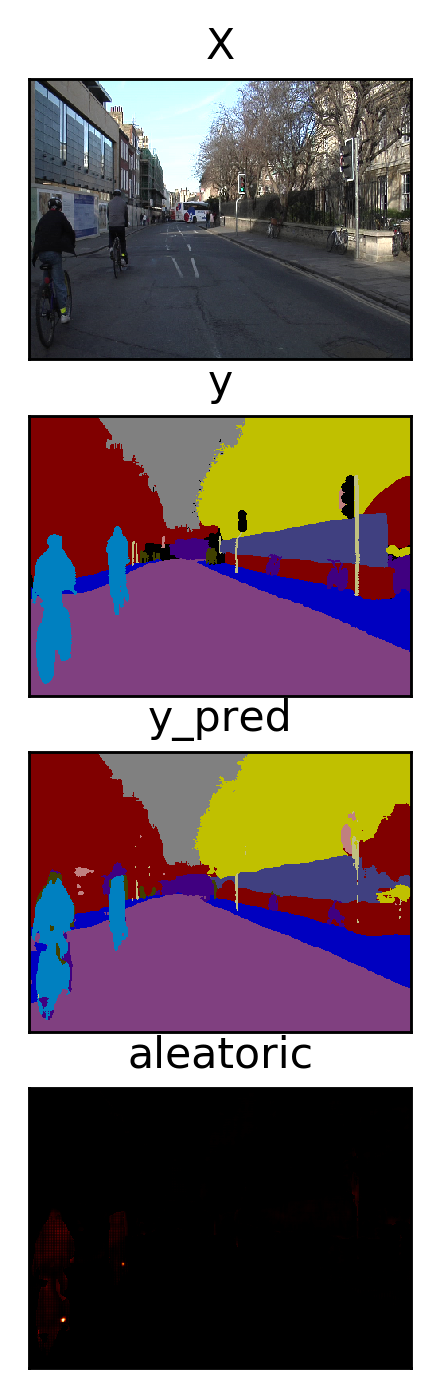

In [19]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

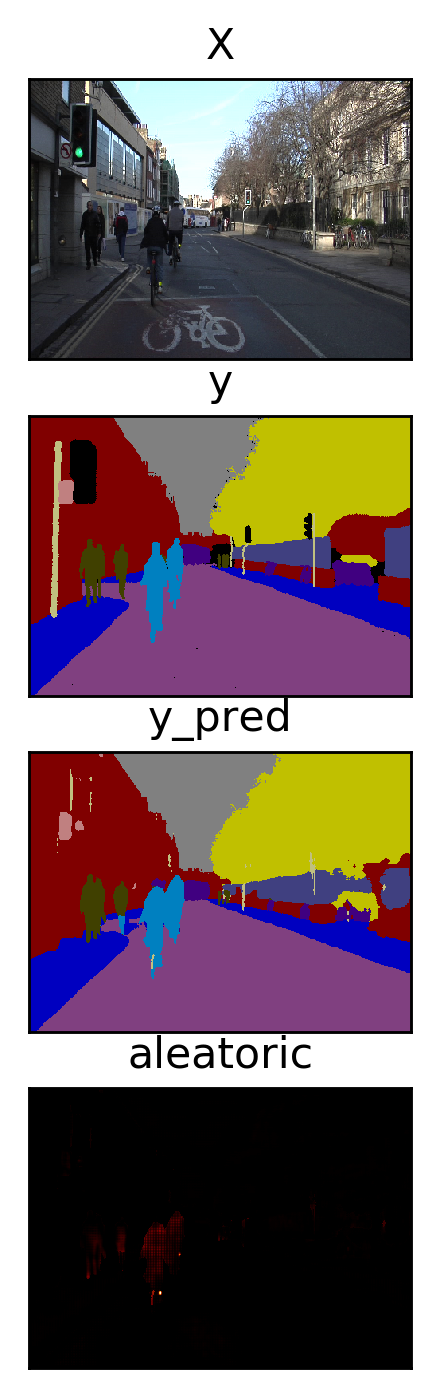

In [20]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

### Test

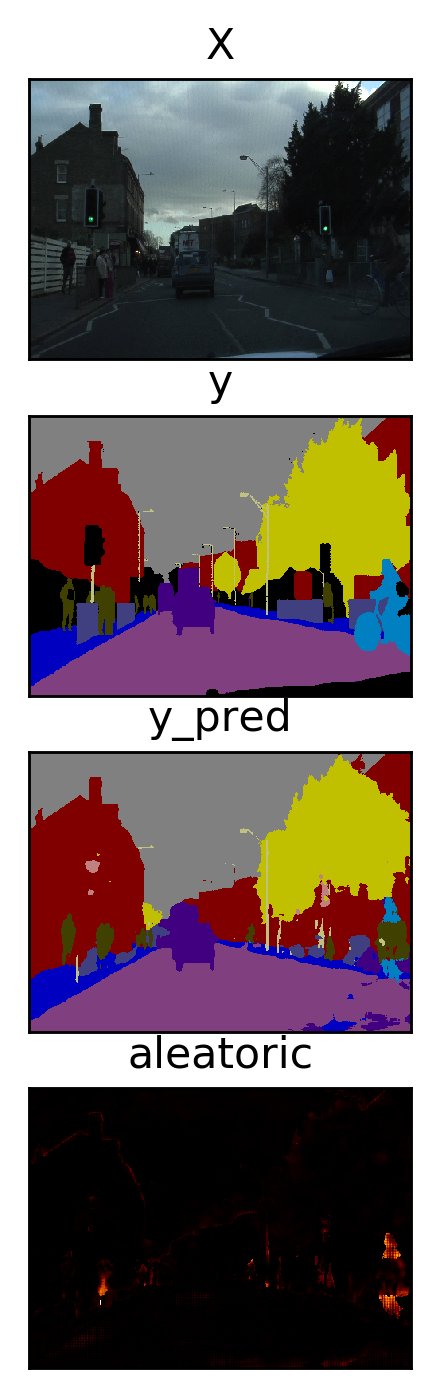

In [21]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/tiramisu-bayesian/aleatoric/0.png', transparent=True, bbox_inches='tight')

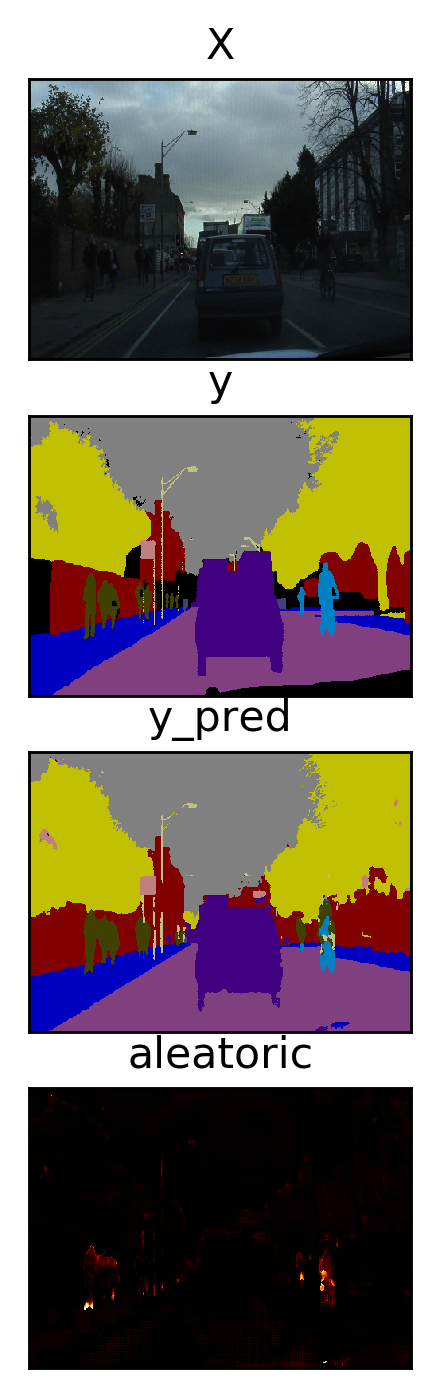

In [22]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/tiramisu-bayesian/aleatoric/1.png', transparent=True, bbox_inches='tight')

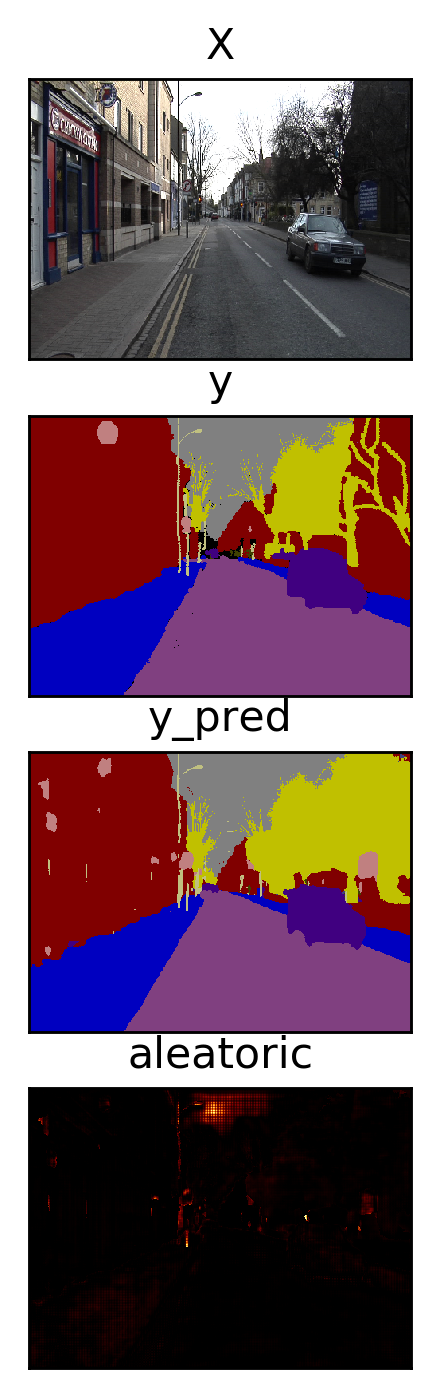

In [23]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/tiramisu-bayesian/aleatoric/2.png', transparent=True, bbox_inches='tight')

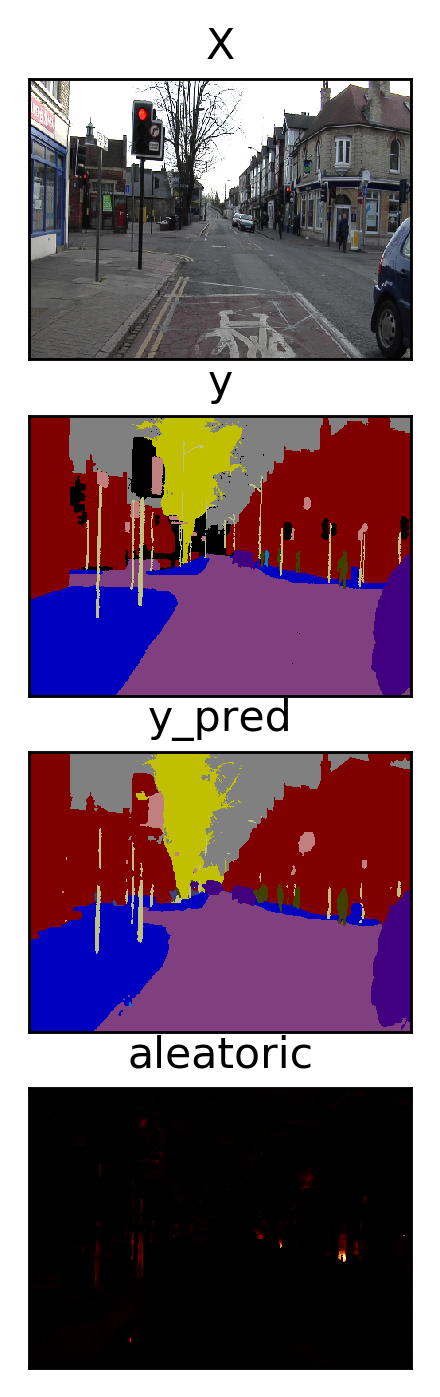

In [24]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = plot.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/tiramisu-bayesian/aleatoric/3.png', transparent=True, bbox_inches='tight')

# Video

In [25]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/tiramisu-bayesian/aleatoric/{}'.format(video_file)

In [26]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict_aleatoric)

100%|██████████| 6600/6600 [28:00<00:00,  3.93it/s]
